# Modify aviation emissions
We use data from https://www.flightradar24.com/data/statistics to modify all NOx emissions

In [1]:
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd


import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time

In [2]:
input_folder = "../input/"
output_folder = "../output/aviation/"
nox_input = "NOx-em-AIR-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_flights = "total-number-of-flights.csv"

month_plat = "04"

scenario_string = "_flightrad_mp{}.nc".format(month_plat)

def convert_years_to_days(year):
    return (year - 2015) * 365

# We don't want data after 2050. Data is recorded in 365-day years
tcutoff = convert_years_to_days(2050.99)
key_variable = "NOx_em_AIR_anthro"

In [3]:
flights_change = pd.read_csv(input_folder + input_flights)
flights_change.head(20)

,DateTime,7-day moving average,Number of flights
0,06/01/2020,168434,184566
1,07/01/2020,171657,183328
2,08/01/2020,176691,179306
3,09/01/2020,178076,185552
4,10/01/2020,179282,183890
5,11/01/2020,177687,154564
6,12/01/2020,176103,161515
7,13/01/2020,174255,171632
8,14/01/2020,172803,173162
9,15/01/2020,173944,187297


In [4]:
flights_change

,DateTime,7-day moving average,Number of flights
0,06/01/2020,168434,184566
1,07/01/2020,171657,183328
2,08/01/2020,176691,179306
3,09/01/2020,178076,185552
4,10/01/2020,179282,183890
...,...,...,...
153,07/06/2020,108754,90962
154,08/06/2020,107185,106809
155,09/06/2020,105888,109757
156,10/06/2020,105707,115051


# Complementing the flight data
We will use a linear trend to continue the flight data until we reach a level of . 

In [5]:
flights0 = np.mean(flights_change["Number of flights"].loc[[date[3:5] == "01" for date in flights_change["DateTime"]]])
flightsplat = flights0 - 2 / 3 * (flights0 - np.mean(
        flights_change["Number of flights"].loc[[date[3:5] == month_plat for date in flights_change["DateTime"]]]
    )
)
start_fit = 120
fit = np.polyfit(range(len(flights_change["Number of flights"]))[start_fit:], flights_change["Number of flights"][start_fit:], 1)
xs = range(start_fit, 366)
fitted_trend = np.poly1d(fit)(xs)
print(flights0)
print(flightsplat)

178763.15384615384
105982.74017094017


In [6]:
flights_list = list(flights_change["Number of flights"][:]) + [
    min(np.poly1d(fit)(x), flightsplat) for x in range(len(flights_change["Number of flights"][:]), 366)
]

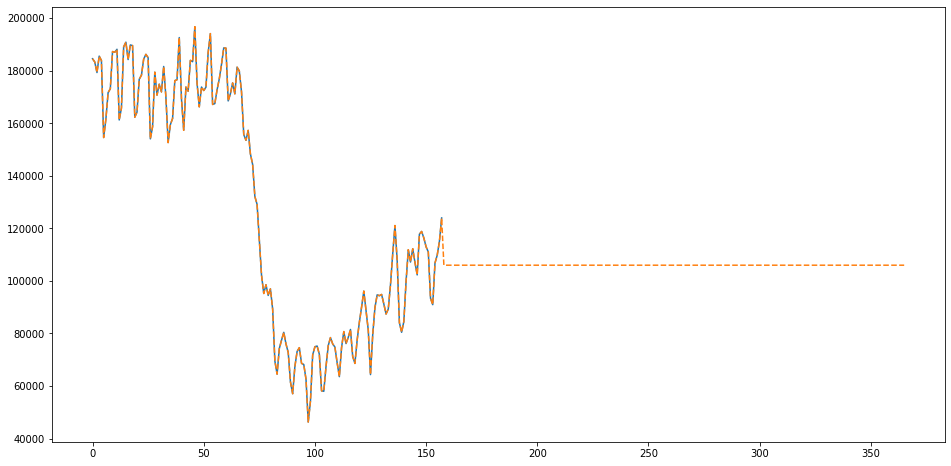

In [7]:
plt.figure(figsize=(16, 8))
plt.plot(range(len(flights_change["Number of flights"])), flights_change["Number of flights"])
plt.plot(range(366), flights_list, linestyle="--")

In [8]:
flights = pd.DataFrame({"Flights": flights_list, "month": None})

In [9]:
flights

,Flights,month
0,184566.000000,None
1,183328.000000,None
2,179306.000000,None
3,185552.000000,None
4,183890.000000,None
...,...,...
361,105982.740171,None
362,105982.740171,None
363,105982.740171,None
364,105982.740171,None


In [10]:
flights["date"] = [date(year = 2020, month = 1, day =6) + timedelta(days=i) for i in flights.index]
flights["month"] = [i.month for i in flights["date"]]
flights["date"]

0      2020-01-06
1      2020-01-07
2      2020-01-08
3      2020-01-09
4      2020-01-10
          ...    
361    2021-01-01
362    2021-01-02
363    2021-01-03
364    2021-01-04
365    2021-01-05
Name: date, Length: 366, dtype: object

In [11]:
monthly_flight_chng = flights.groupby("month").mean() / flights0

In [12]:
monthly_flight_chng

,Flights
month,
1,0.934333
2,0.969684
3,0.774975
4,0.389300
5,0.514691
6,0.602388
7,0.592867
8,0.592867
9,0.592867


## Add interpolated years
To ensure that 2020 is anomalous, we will interpolate the expected values from 2019 and 2023 before modifying 2020. 

In [13]:
# Since the data is extensive, we will cut it up first
start = datetime.now()
data = cutoff_netcdf_time(input_folder, output_folder, nox_input, tcutoff, scenario_string="", compress=False)
end = datetime.now()
print(end - start)

0:00:08.839063


In [14]:
start = datetime.now()
for yeardif in [4, 6, 7]:
    for i in range(1,13):
        insert_interpolated_point(data, yeardif * 365 + data.variables["time"][(i - 1)], 12, i)
    end = datetime.now()
    print(end - start)
    print("Inserted data for {}".format(yeardif))

0:00:51.380712
Inserted data for 4
0:01:26.871712
Inserted data for 6
0:02:02.263693
Inserted data for 7


# Perform the emissions modifications
We reduce the emissions in 2020 by a continuously changing amount, and the emissions in 2021 by a constant amount. 

In [15]:
output = data.variables[key_variable][:]
for time in range(1, 13):
    timeind = np.where(
        abs(data.variables["time"][:] - convert_years_to_days(2020 + (time - 0.5)/12)) == min(
            abs(data.variables["time"][:] - convert_years_to_days(2020 + (time - 0.5)/12))
        )
    )
    output[timeind, ...] *= monthly_flight_chng["Flights"].loc[time]
    timeind = np.where(
        abs(data.variables["time"][:] - convert_years_to_days(2021 + (time - 0.5)/12)) == min(
            abs(data.variables["time"][:] - convert_years_to_days(2021 + (time - 0.5)/12))
        )
    )    
    output[timeind, ...] *= monthly_flight_chng["Flights"].iloc[-1]

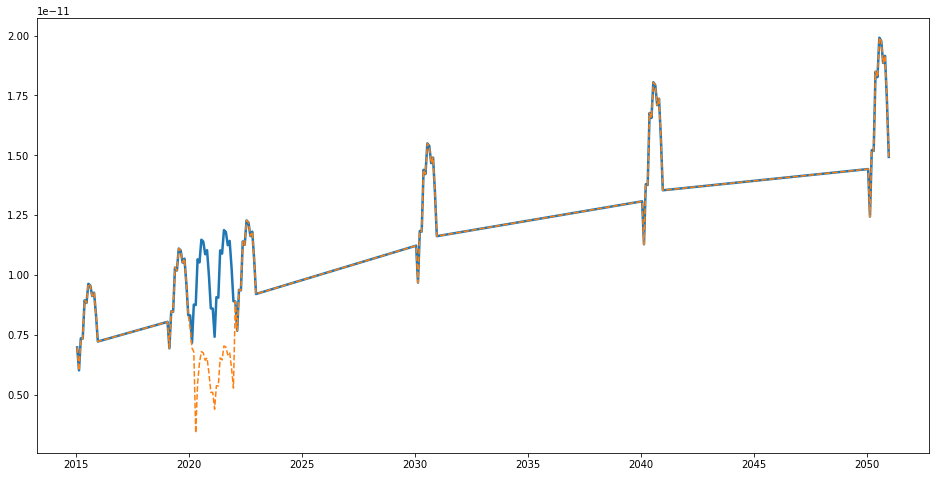

In [16]:
plt.figure(figsize=(16, 8))
plt.plot(data.variables["time"][:] / 365 + 2015, data.variables["NOx_em_AIR_anthro"][:, 0, 283, 360], linewidth=2.5)
plt.plot(data.variables["time"][:] / 365 + 2015, output[:, 0, 283, 360],  linestyle="--")

In [17]:
data.variables[key_variable][...] = output[...]
data.close()
# We also want to compress the data again
data = copy_netcdf_file(
        "cut_" + nox_input, output_folder, output_folder, scenario_string, compress=True
)

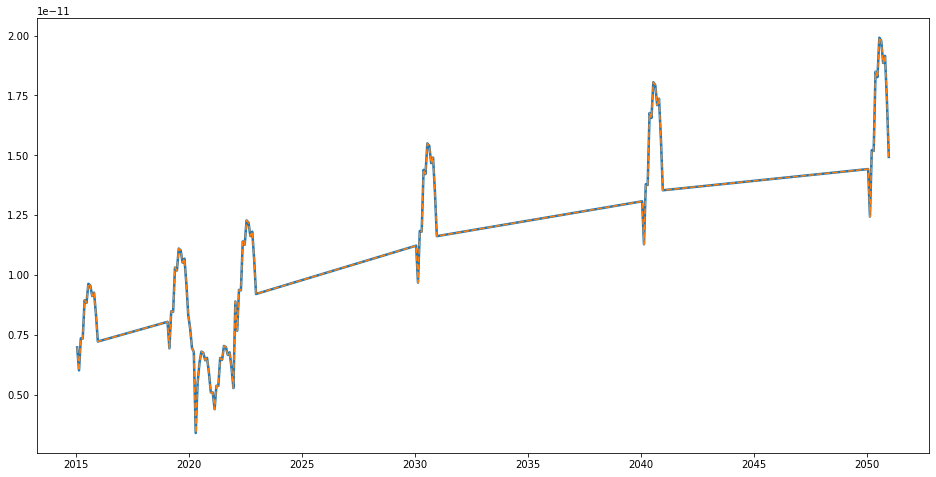

In [18]:
plt.figure(figsize=(16, 8))
plt.plot(data.variables["time"][:] / 365 + 2015, data.variables["NOx_em_AIR_anthro"][:, 0, 283, 360], linewidth=2.5)
plt.plot(data.variables["time"][:] / 365 + 2015, output[:, 0, 283, 360],  linestyle="--")

In [19]:
data.close()